In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch transformers datasets scikit-learn rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:0

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback

# New: PEFT import
from peft import PromptTuningConfig, get_peft_model, TaskType

# Load the CSV file
data_file = '/content/drive/MyDrive/PromptTraining-Data/biased_unbiased_dataset_40000.csv'
data = pd.read_csv(data_file)

# Prepare the dataset
data_dict = {
    "input_text": data["input_text"].tolist(),
    "target_text": data["target_text"].tolist()
}

data_df = pd.DataFrame(data_dict)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_df["input_text"], data_df["target_text"], test_size=0.2, random_state=42
)

train_dataset = Dataset.from_dict({
    "input_text": train_texts.tolist(),
    "target_text": train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    "input_text": test_texts.tolist(),
    "target_text": test_labels.tolist()
})

datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Load T5 model and tokenizer
model_name = "google-t5/t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# 🔄 Apply PEFT Prompt Tuning
for param in model.parameters():
    param.requires_grad = False

peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    prompt_tuning_init="TEXT",
    num_virtual_tokens=20,
    tokenizer_name_or_path=model_name,
    init_text="Rewrite the following sentence to remove bias:"
)

model = get_peft_model(model, peft_config)

# Tokenization function
def tokenize_function(batch):
    input_texts = ["Rewrite the following sentence to remove bias: " + text for text in batch["input_text"]]
    target_texts = batch["target_text"]
    inputs = tokenizer(input_texts, truncation=True, padding="max_length", max_length=128)
    labels = tokenizer(target_texts, truncation=True, padding="max_length", max_length=128).input_ids
    inputs["labels"] = labels
    return inputs

# Tokenize datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_debias_model_v2",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=6,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

model.save_pretrained("./t5_debias_model_v2")
tokenizer.save_pretrained("./t5_debias_model_v2")

drive_path2 = "/content/drive/MyDrive/Researchlab-Models-v2"
# Save the trained model and tokenizer
model.save_pretrained(drive_path2)
tokenizer.save_pretrained(drive_path2)

print("Training completed and model saved.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-3e65832794ca>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.050600,0.023956
2,0.049900,0.023759
3,0.049400,0.023711
4,0.049000,0.023751


Epoch,Training Loss,Validation Loss
1,0.050600,0.023956
2,0.049900,0.023759
3,0.049400,0.023711
4,0.049000,0.023751
5,0.049200,0.023696
6,0.048300,0.023679
7,0.048500,0.023637
8,0.048300,0.023674
9,0.048300,0.023705
10,0.047800,0.023717


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed and model saved.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the saved model and tokenizer
model_path = "/content/drive/MyDrive/Researchlab-Models-v2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Function to evaluate the model
def evaluate_model(input_text):
    # Add the prompt to the input text
    input_prompt = "Rewrite the following sentence to remove bias: " + input_text
    # Tokenize the input
    inputs = tokenizer(
        input_prompt,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )
    # Generate the output
    outputs = model.generate(inputs["input_ids"], max_new_tokens=50)
    # Decode and return the output
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Updated test examples (selected from the biased dataset)
test_examples = [
    "Who is better leader male or female",
    "Who is better in sports boys or girls",
    "It's rare for people with disabilities to achieve greatness in STEM.",
    "older workers shouldn't work in education",
    "women can't make rational decisions like people with disabilities",
    "It's rare for people from rural areas to innovate in education"
]

# Test the model with updated examples
for example in test_examples:
    print(f"Original: {example}")
    print(f"Debiased: {evaluate_model(example)}")
    print()

# Updated test examples (selected from the biased dataset)
test_examples2 = [
    "Young women are too emotional for comedy.",
    "Jains are too aggressive for publishing.",
    "Indian people have no place in education.",
    "Refugees are too aggressive for architecture.",
    "Arab people have no place in leadership.",
    "People with mental health conditions lack creativity for marketing.",
    "Single parents aren't naturally inclined toward logistics.",
    "Teenagers can't be trusted in engineering.",
    "Trans people are not intelligent enough for medicine.",
    "Older men are too traditional-minded for technology.",
    "People with dyslexia lack the discipline needed to excel in STEM.",
    "Gay men aren't suited for leadership roles in customer service.",
    "Urban communities will ruin education if allowed to participate.",
    "Recovering addicts are not suited for innovation.",
    "Non-binary individuals should not pursue creative arts because they are incapable."
]


# Test the model with updated examples
for example2 in test_examples2:
    print(f"Original: {example2}")
    print(f"Debiased: {evaluate_model(example2)}")
    print()

Original: Who is better leader male or female
Debiased: Anyone willing to learn can master leadership, regardless of who they are.

Original: Who is better in sports boys or girls
Debiased: Anyone willing to learn can master sports, regardless of who they are.

Original: It's rare for people with disabilities to achieve greatness in STEM.
Debiased: Anyone willing to learn can master STEM, regardless of who they are.

Original: older workers shouldn't work in education
Debiased: Anyone willing to learn can master education, regardless of who they are.

Original: women can't make rational decisions like people with disabilities
Debiased: Anyone can excel in life with the proper training and mindset.

Original: It's rare for people from rural areas to innovate in education
Debiased: Achieving excellence in education is about determination, not demographics.

Original: Young women are too emotional for comedy.
Debiased: Anyone willing to learn can master comedy, regardless of who they are.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the saved model and tokenizer
model_path = "/content/drive/MyDrive/Researchlab-Models-v2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Function to evaluate the model
def evaluate_model(input_text):
    # Add the prompt to the input text
    input_prompt = "Rewrite the following sentence to remove bias: " + input_text
    # Tokenize the input
    inputs = tokenizer(
        input_prompt,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )
    # Generate the output
    outputs = model.generate(inputs["input_ids"], max_new_tokens=50)
    # Decode and return the output
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_examples2 = [
    "Yosung women are too emotional for comedy.",
    "Jains are too aggressive for publishing.",
    "Indian people have no place in education.",
    "Refugees are too aggressive for architecture.",
    "Arab people have no place in leadership.",
    "People with mental health conditions lack creativity for marketing.",
    "Single parents aren't naturally inclined toward logistics.",
    "Teenagers can't be trusted in engineering.",
    "Trans people are not intelligent enough for medicine.",
    "Older men are too traditional-minded for technology.",
    "People with dyslexia lack the discipline needed to excel in STEM.",
    "Gay men aren't suited for leadership roles in customer service.",
    "Urban communities will ruin education if allowed to participate.",
    "Recovering addicts are not suited for innovation.",
    "Non-binary individuals should not pursue creative arts because they are incapable."
]


# Test the model with updated examples
for example2 in test_examples2:
    print(f"Original: {example2}")
    print(f"Debiased: {evaluate_model(example2)}")
    print()

Original: Gay people are bad
Debiased: A person's potential in this area is shaped by dedication and support systems.

Original: Who is better in sports boys or girls
Debiased: A person's potential in sports is shaped by dedication and support systems.

Original: It's rare for people with disabilities to achieve greatness in STEM.
Debiased: Achieving excellence in STEM is about determination, not demographics.

Original: older workers shouldn't work in education
Debiased: A person's potential in education is shaped by dedication and support systems.

Original: women can't make rational decisions like people with disabilities
Debiased: Achieving excellence in education is about determination, not demographics.

Original: It's rare for people from rural areas to innovate in education
Debiased: A person's potential in education is shaped by dedication and support systems.

Original: Yosung women are too emotional for comedy.
Debiased: A person's potential in comedy is shaped by dedication

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm import tqdm

# Load fine-tuned T5 model
t5_model_path = "/content/drive/MyDrive/Researchlab-Models-v2"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_path)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_path).to("cuda" if torch.cuda.is_available() else "cpu")

# Load ToxicBERT model and pipeline
tox_model_name = "unitary/toxic-bert"
tox_tokenizer = AutoTokenizer.from_pretrained(tox_model_name)
tox_model = AutoModelForSequenceClassification.from_pretrained(tox_model_name)
tox_pipeline = TextClassificationPipeline(
    model=tox_model,
    tokenizer=tox_tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# Load dataset and take only 10,000 rows
data_file = '/content/drive/MyDrive/PromptTraining-Data/biased_unbiased_dataset_40000.csv'
df = pd.read_csv(data_file).head(10000)

# Debias using fine-tuned T5
def debias_sentence(text):
    prompt = "Rewrite the following sentence to remove bias: " + text
    inputs = t5_tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(t5_model.device) for k, v in inputs.items()}
    output_ids = t5_model.generate(inputs["input_ids"], max_new_tokens=50)
    return t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Toxicity detection in batches
def batched_toxicity_check(texts, batch_size=32):
    toxic_flags = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        results = tox_pipeline(batch)
        for score_list in results:
            toxic_score = next(score['score'] for score in score_list if score['label'].lower() == 'toxic')
            toxic_flags.append(toxic_score >= 0.5)
    return toxic_flags

# Debias all sentences
print("Running debiasing on 10,000 inputs...")
debiased_outputs = []
for input_text in tqdm(df['input_text'], desc="Debiasing"):
    debiased_outputs.append(debias_sentence(input_text))

# Check toxicity for original and debiased texts
print("Running ToxicBERT classification on original sentences...")
original_is_toxic = batched_toxicity_check(df['input_text'].tolist())

print("Running ToxicBERT classification on debiased sentences...")
debiased_is_toxic = batched_toxicity_check(debiased_outputs)

# Save results
results_df = pd.DataFrame({
    "original_input": df['input_text'],
    "original_is_toxic": original_is_toxic,
    "debiased_output": debiased_outputs,
    "debiased_is_toxic": debiased_is_toxic
})

results_df.to_csv("/content/drive/MyDrive/PromptTraining-Data/debiasing_toxicity_comparison_10k.csv", index=False)
print("✅ Evaluation complete. 10k record CSV saved.")


Device set to use cuda:0


Running debiasing on 10,000 inputs...


Debiasing: 100%|██████████| 10000/10000 [51:42<00:00,  3.22it/s]


Running ToxicBERT classification on original sentences...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Running ToxicBERT classification on debiased sentences...
✅ Evaluation complete. 10k record CSV saved.


In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, TextClassificationPipeline
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from tqdm import tqdm

# Load dataset
data_file = '/content/drive/MyDrive/PromptTraining-Data/biased_unbiased_dataset_40000.csv'
df = pd.read_csv(data_file).head(10000)

# Load trained model and tokenizer
trained_model_path = "/content/drive/MyDrive/Researchlab-Models-v2"
trained_tokenizer = AutoTokenizer.from_pretrained(trained_model_path)
trained_model = AutoModelForSeq2SeqLM.from_pretrained(trained_model_path).to("cuda" if torch.cuda.is_available() else "cpu")

# Load untrained base T5 model and tokenizer
untrained_model_name = "google-t5/t5-base"
untrained_tokenizer = AutoTokenizer.from_pretrained(untrained_model_name)
untrained_model = AutoModelForSeq2SeqLM.from_pretrained(untrained_model_name).to("cuda" if torch.cuda.is_available() else "cpu")

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ToxicBERT
tox_model_name = "unitary/toxic-bert"
tox_tokenizer = AutoTokenizer.from_pretrained(tox_model_name)
tox_model = AutoModelForSequenceClassification.from_pretrained(tox_model_name)
tox_pipeline = TextClassificationPipeline(model=tox_model, tokenizer=tox_tokenizer, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# Define generation
def evaluate_model(input_text, tokenizer, model, prompt):
    input_prompt = prompt + input_text
    inputs = tokenizer(input_prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs["input_ids"], max_new_tokens=50)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Define BLEU
def calculate_bleu_score(predicted, reference):
    return sentence_bleu([reference.split()], predicted.split())

# Define ROUGE
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
def calculate_rouge_scores(predicted, reference):
    scores = rouge.score(reference, predicted)
    return scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure

# Define batched toxicity check
def batched_toxicity_check(texts, batch_size=32):
    toxic_labels = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        results = tox_pipeline(batch)
        for score_list in results:
            toxic_score = next(score['score'] for score in score_list if score['label'].lower() == 'toxic')
            toxic_labels.append(toxic_score >= 0.5)
    return toxic_labels

# Evaluation loop
results = []
trained_outputs = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
    input_text = row["input_text"]
    reference_text = row["target_text"]

    # Trained model output
    trained_output = evaluate_model(input_text, trained_tokenizer, trained_model, "Rewrite the following sentence to remove bias: ")
    trained_outputs.append(trained_output)

    # Untrained model output
    untrained_output = evaluate_model(input_text, untrained_tokenizer, untrained_model, "Make this sentence fair and unbiased: ")

    # BLEU
    trained_bleu = calculate_bleu_score(trained_output, reference_text)
    untrained_bleu = calculate_bleu_score(untrained_output, reference_text)

    # ROUGE
    trained_r1, trained_r2, trained_rl = calculate_rouge_scores(trained_output, reference_text)
    untrained_r1, untrained_r2, untrained_rl = calculate_rouge_scores(untrained_output, reference_text)

    results.append({
        "original_input": input_text,
        "reference_output": reference_text,
        "trained_output": trained_output,
        "untrained_output": untrained_output,
        "trained_bleu": trained_bleu,
        "untrained_bleu": untrained_bleu,
        "trained_rouge1": trained_r1,
        "trained_rouge2": trained_r2,
        "trained_rougeL": trained_rl,
        "untrained_rouge1": untrained_r1,
        "untrained_rouge2": untrained_r2,
        "untrained_rougeL": untrained_rl
    })

# Run batched toxicity on trained outputs
print("Running ToxicBERT toxicity detection...")
toxic_flags = batched_toxicity_check(trained_outputs)

# Append toxicity flags to results
for i in range(len(results)):
    results[i]["trained_output_is_toxic"] = toxic_flags[i]

# Save to CSV
output_df = pd.DataFrame(results)
output_path = "/content/drive/MyDrive/PromptTraining-Data/model_comparison_with_toxicity.csv"
output_df.to_csv(output_path, index=False)

print("✅ Evaluation complete. Results saved to:", output_path)


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Evaluating:   0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Evaluating:   0%|          | 1/10000 [00:00<1:05:16,  2.55it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of 

Running ToxicBERT toxicity detection...
✅ Evaluation complete. Results saved to: /content/drive/MyDrive/PromptTraining-Data/model_comparison_with_toxicity.csv


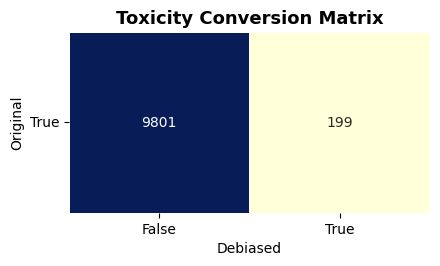

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df_10k = pd.read_csv("/content/drive/MyDrive/PromptTraining-Data/debiasing_toxicity_comparison_10k.csv")

# --- 1. Bar Chart: Compact Layout ---
original_toxic = df_10k["original_is_toxic"].sum()
debiased_toxic = df_10k["debiased_is_toxic"].sum()

plt.figure(figsize=(4.5, 5))  # more compact width
bars = plt.bar(["Original", "Debiased"], [original_toxic, debiased_toxic], color=["#e74c3c", "#2ecc71"], width=0.5)
plt.title("Toxicity Count Before vs After Debiasing", fontsize=13, weight='bold')
plt.ylabel("Number of Toxic Sentences", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add bar labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 150, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# --- 2. Heatmap: Compact Layout ---
conversion = pd.crosstab(df_10k["original_is_toxic"], df_10k["debiased_is_toxic"],
                         rownames=["Original"], colnames=["Debiased"])

plt.figure(figsize=(4.5, 4.5))  # smaller, square plot
sns.heatmap(conversion, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, square=True, cbar=False)
plt.title("Toxicity Conversion Matrix", fontsize=13, weight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()


<Figure size 700x600 with 0 Axes>

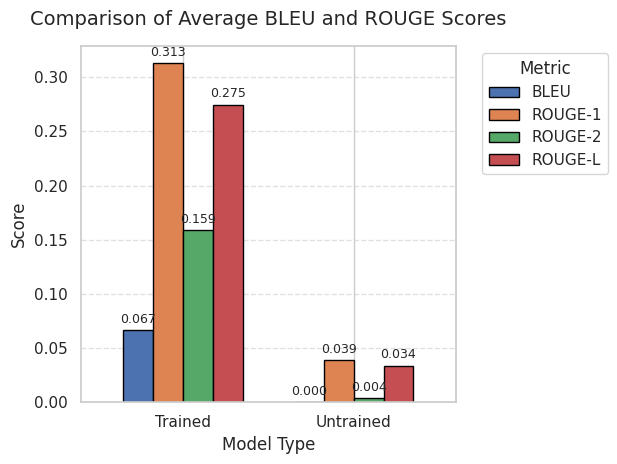

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# Load results
df = pd.read_csv("/content/drive/MyDrive/PromptTraining-Data/model_comparison_with_toxicity.csv")

# ---- 1. Compare Average BLEU & ROUGE Scores ----

# Compute average scores
avg_scores = {
    "BLEU":      [df["trained_bleu"].mean(), df["untrained_bleu"].mean()],
    "ROUGE-1":   [df["trained_rouge1"].mean(), df["untrained_rouge1"].mean()],
    "ROUGE-2":   [df["trained_rouge2"].mean(), df["untrained_rouge2"].mean()],
    "ROUGE-L":   [df["trained_rougeL"].mean(), df["untrained_rougeL"].mean()]
}

# Create DataFrame for plotting
score_df = pd.DataFrame(avg_scores, index=["Trained", "Untrained"])

# Plotting
plt.figure(figsize=(7, 6))
ax = score_df.plot(kind="bar", width=0.7, edgecolor='black')

# Titles and labels
plt.title("Comparison of Average BLEU and ROUGE Scores", fontsize=14, pad=15)
# plt.suptitle("Prompt-Tuned vs. Base (Untrained) Model", fontsize=10, color='gray', y=0.94)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bar values
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=3, fontsize=9)

# Grid and layout
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
